In [123]:
import json

scientific_articles = []
with open('json/related-articles_pro-science.json', 'r') as storage:
    info = json.loads(storage.read())
    for article in info:
        scientific_articles.append(article[1])

conspiracy_articles = [] 
with open('json/related-articles_conspiracy.json', 'r') as storage:
    info = json.loads(storage.read())
    for article in info:
        conspiracy_articles.append(article[1])

min_len = min(len(scientific_articles), len(conspiracy_articles))
scientific_articles = scientific_articles[:min_len]
conspiracy_articles = conspiracy_articles[:min_len]

print(min_len)

8


In [124]:
from nltk import word_tokenize
from nltk.corpus import stopwords
from dateutil.parser import parse
from nltk.stem import WordNetLemmatizer
from article_finder import ArticleFinder
import matplotlib.pyplot as plt

import string
import nltk

class BagOfWords:
    def __init__(self, tokenized_paragraph: list, is_positive: bool):
        self.sentences = tokenized_paragraph
        self.is_positive = is_positive

    def tokenize(self):
        self.words = []
        for sentence in self.sentences:
            for word in word_tokenize(sentence):
                self.words.append(word)

    def to_lower_case(self):
        for i in range(len(self.words)):
            self.words[i] = self.words[i].lower()

    def clean_data(self):
        noise = ['...', "n't"]
        def is_time_or_date(word):  
            try:
                parsed = parse(word)
                return True
            except:
                return False

        def is_link(word):
            for suffix in ArticleFinder.suffixes:
                if suffix in word:
                    return True
            return False

        # rn = set()

        for i in range(len(self.words)-1, -1, -1):
            if len(self.words[i]) <= 2 or self.words[i].isnumeric() or is_time_or_date(self.words[i]) or self.words[i] in noise or is_link(self.words[i]):
                self.words.pop(i)
                continue
        
            # shave punctation off of beginnings and from the end
            start_ind, end_ind = -1, -1
            for j in range(len(self.words[i])):
                if self.words[i][j] in string.ascii_lowercase or self.words[i][j].isnumeric():
                    start_ind = j
                    break
            for j in range(len(self.words[i])-1, -1, -1):
                if self.words[i][j] in string.ascii_lowercase or self.words[i][j].isnumeric():
                    end_ind = j
                    break

            if (start_ind == 0 and end_ind == len(self.words[i])-1) or start_ind >= end_ind:
                continue

            self.words[i] = self.words[i][start_ind:end_ind+1]
            # rn.add((self.words[i], self.words[i][start_ind:end_ind+1]))

    def remove_stop_words(self):
        for i in range(len(self.words)-1, -1, -1):
            if self.words[i] in stopwords.words('english'):
                self.words.pop(i)  

    def normalize_words(self):
        def get_part_of_speech(provided_word):
            _, part_of_speech = nltk.pos_tag([provided_word])[0]
            if 'NN' in part_of_speech:
                return 'n'
            if 'VB' in part_of_speech:
                return 'v'
            if 'JJ' in part_of_speech:
                return 'a'
            if 'RB' in part_of_speech:
                return 'r'
            return 'n'

        lemmatizer = WordNetLemmatizer()
        for i in range(len(self.words)):
            self.words[i] = lemmatizer.lemmatize(self.words[i], get_part_of_speech(self.words[i]))

    def create_frequency_chart(self):
        self.freqChart = dict()

        for word in self.words:
            if word not in self.freqChart:
                self.freqChart[word] = 1
            else:
                self.freqChart[word] += 1

        # sorting in ascending order by value
        self.freqChart = {word: self.freqChart[word] for word in sorted(self.freqChart, key=self.freqChart.get, reverse=True)}

    def plot_frequency_chart(self):
        words = list(self.freqChart.keys())[:100]
        frequencies = list(self.freqChart.values())[:100]

        plt.figure(figsize=(20, 5))
        plt.margins(x=0, tight=True)
        plt.bar(words, frequencies, color ='green')

        # setting title and labels
        plt.xlabel("Distinct Words")
        plt.tick_params(axis='x', which='major', labelsize=9)
        plt.xticks(rotation = 90)

        plt.ylabel(f"Frequency of Words in {self.is_positive}")
        plt.title("Frequency Chart")

        # loading the plot
        plt.show()

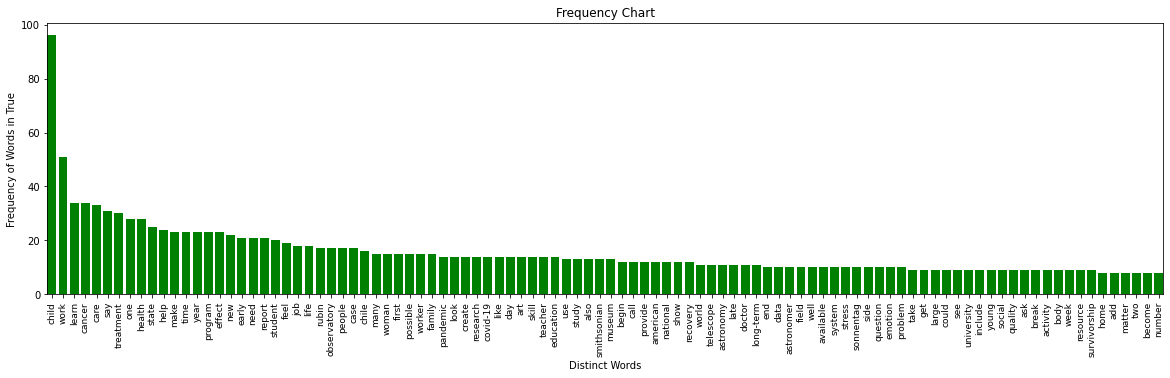

In [125]:
a = BagOfWords(scientific_articles, True)

a.tokenize()
a.to_lower_case()
a.clean_data()
a.remove_stop_words()
a.normalize_words() # todo: improve part of speech performance
a.create_frequency_chart()
a.plot_frequency_chart()

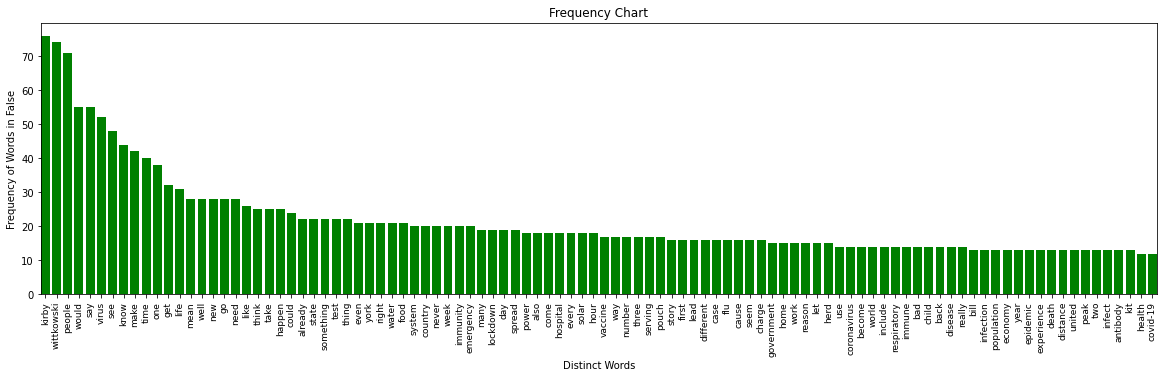

In [126]:
b = BagOfWords(conspiracy_articles, False)

# assuming rn that everything is clean because of testing on 'a', will test later
b.tokenize()
b.to_lower_case()
b.clean_data()
b.remove_stop_words()
b.normalize_words() # todo: improve part of speech performance
b.create_frequency_chart()
b.plot_frequency_chart()

In [127]:
# determine common words between the two sets of words
common_words = dict()
for word, count in a.freqChart.items():
    if word in b.freqChart:
        diff_count = count - b.freqChart[word]
        common_words[word] = diff_count/(count + b.freqChart[word])

# remove all with count 0 
# common_words = dict(filter(lambda elem: elem[1] != 0, common_words.items()))

# sorting the dictionary in descending order
common_words = {word: common_words[word] for word in sorted(common_words, key=common_words.get, reverse=True)}

In [128]:
common_words

{'care': 0.9411764705882353,
 'treatment': 0.9354838709677419,
 'learn': 0.8888888888888888,
 'teacher': 0.8666666666666667,
 'american': 0.8461538461538461,
 'national': 0.8461538461538461,
 'recovery': 0.8461538461538461,
 'long-term': 0.8333333333333334,
 'write': 0.7777777777777778,
 'family': 0.7647058823529411,
 'early': 0.75,
 'trip': 0.75,
 'community': 0.75,
 'development': 0.75,
 'child': 0.7454545454545455,
 'job': 0.7142857142857143,
 'universe': 0.7142857142857143,
 'note': 0.7142857142857143,
 'tend': 0.7142857142857143,
 'healthy': 0.7142857142857143,
 'five': 0.7142857142857143,
 'age': 0.7142857142857143,
 'practice': 0.7142857142857143,
 'summary': 0.7142857142857143,
 'available': 0.6666666666666666,
 'service': 0.6666666666666666,
 'behavior': 0.6666666666666666,
 'visit': 0.6666666666666666,
 'research': 0.6470588235294118,
 'quality': 0.6363636363636364,
 'body': 0.6363636363636364,
 'report': 0.6153846153846154,
 'help': 0.6,
 'sky': 0.6,
 'rise': 0.6,
 'psycholo

In [129]:
print(len(common_words))
print(sum(y > 0 for _, y in common_words.items()))
print(sum(y < 0 for _, y in common_words.items()))

679
187
330


In [130]:
# plot a graph containing words on either side
x_axis, y_axis = [], []
for word, value in common_words.items():
    x_axis.append(word)
    y_axis.append(value)

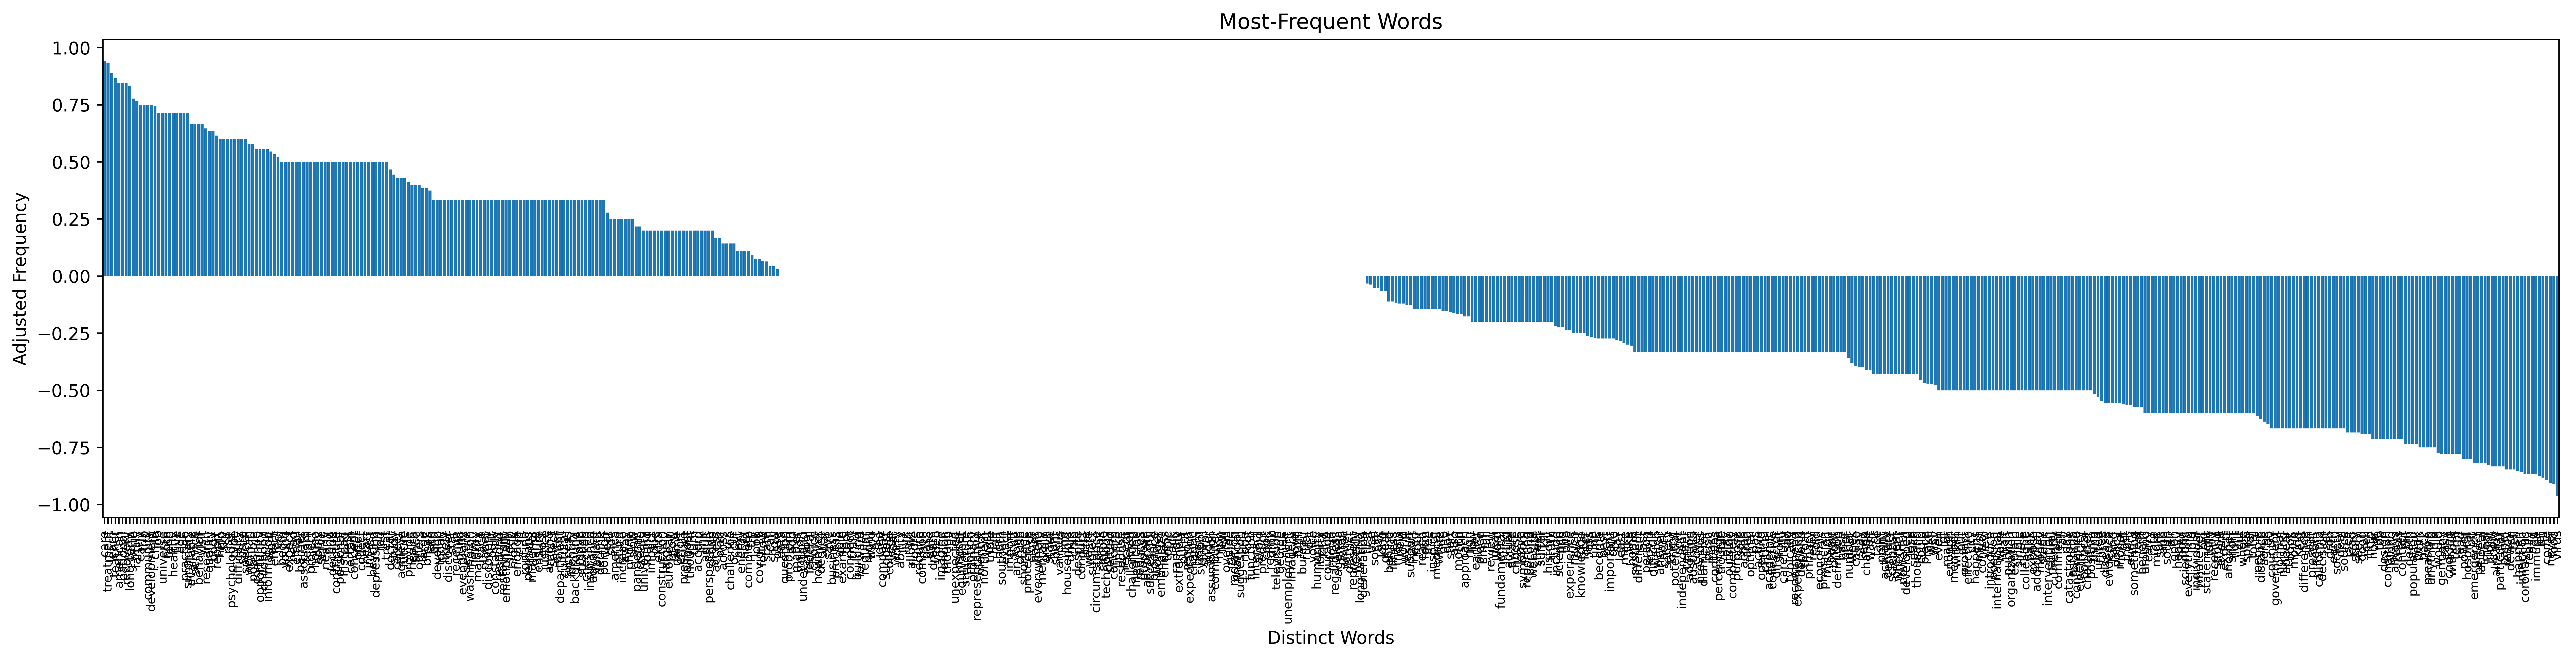

In [131]:
plt.figure(figsize=(25, 5), dpi=500)
plt.margins(x=0, tight=True)
plt.xlabel("Distinct Words")
plt.ylabel("Adjusted Frequency")
plt.title("Most-Frequent Words")
plt.bar(x_axis, y_axis)
plt.tick_params(axis='x', which='major', labelsize=7)
plt.xticks(rotation = 90)
plt.show()

In [132]:
# extract 20 most common words
sorted_words = []
for key, value in common_words.items():
    sorted_words.append([abs(value), key])
sorted_words.sort(reverse=True)

# take 20 with highest magnitudes  
relevant_words = sorted_words[:20]

# give the sign back
for word in relevant_words:
    word[0] = common_words[word[1]]

relevant_words.sort()

In [140]:
relevant_words

[[-0.9622641509433962, 'virus'],
 [-0.9090909090909091, 'food'],
 [-0.9047619047619048, 'never'],
 [-0.8947368421052632, 'come'],
 [-0.8823529411764706, 'flu'],
 [-0.875, 'let'],
 [-0.8666666666666667, 'bad'],
 [-0.8666666666666667, 'coronavirus'],
 [-0.8666666666666667, 'immune'],
 [-0.8666666666666667, 'really'],
 [-0.8571428571428571, 'infection'],
 [-0.8518518518518519, 'happen'],
 [-0.8461538461538461, 'ready'],
 [-0.8461538461538461, 'tell'],
 [0.8461538461538461, 'national'],
 [0.8461538461538461, 'recovery'],
 [0.8666666666666667, 'teacher'],
 [0.8888888888888888, 'learn'],
 [0.9354838709677419, 'treatment'],
 [0.9411764705882353, 'care']]

- relevance detection
    - problem
        - having issues detecting whether an article is actually about COVID or not
        - previously showed with titles, when changed that with words, ending up picking
    - solution
        - currently, as checking in the articles was not very good, am now checking in the titles
        - method of detecting whether an article is related to COVID or not
        - should I have overlapping keywords (based on current method)
- imbalance between scientific and conspiracy articles
    - number of websites on MediaBiasFactCheck
    - positive and negative numbers after sorting
        - common_words
        - relevant_words
- what to do with words with frequency zero, showing up as a big gap in the chart
- parsing is very resource-intensive

plan for next week:
- split up data into testing, training set
    - in an 80-20 split
    - do this individually for scientific articles and conspiracy articles, then merge the two sets together
- after this, evaluation of well the system works with a ML model will be good
    - train model and redo-word frequency part once for the testing set and once for the training set (to prevent data leakage)
    - generate table for training and testing data (2 tables)
        - columns: for each of the 20 keywords
        - rows: count for each keyword in an article  
        - add a final column to the right displaying whether the article was a conspiracy or scientific (0 = conspiracy, 1 = scientific) 
    - train model with various different methods and evaluate test set  

In [145]:
# build the dataframe
import pandas as pd

cols = {}
for word in relevant_words:
    cols[word[1]] = []

# # adding scientific rows
# for article in scientific_articles:
#     for word in cols:
#         cols[word].append(article.lower().count(word))

# data_set = pd.DataFrame(data = cols)

# data_set['article_type'] = 'scientific'

# # get the number of rows
# print(data_set.shape[0])

# adding conspiracy row
# for article in conspiracy_articles:
#     for word in cols:
#         cols[word]


In [148]:
data_set

1

In [136]:
X = data_set.iloc[:, :-1]
y = data_set.iloc[:, -1]

In [137]:
X

,virus,food,never,come,flu,let,bad,coronavirus,immune,really,infection,happen,ready,tell,national,recovery,teacher,learn,treatment,care
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,0,1,0,1,0,1,0,0,1,0,3,0,0,0,0,5
2,0,0,0,1,0,2,0,0,0,0,0,0,2,0,2,10,4,2,0,1
3,0,0,1,3,0,0,0,0,0,0,0,1,0,0,4,0,2,18,0,12
4,0,0,0,1,0,0,0,0,0,0,0,1,0,1,5,0,8,12,0,2
5,0,1,0,0,0,5,0,0,1,0,1,2,0,1,0,2,0,2,29,18
6,1,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,6
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [138]:
y

0    scientific
1    scientific
2    scientific
3    scientific
4    scientific
5    scientific
6    scientific
7    scientific
Name: article_type, dtype: object

In [139]:
# split the dataframe accordingly
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, )
